In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Conv2D, MaxPool2D, Lambda, Bidirectional, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import squeeze
from tensorflow.keras.optimizers import Adam

## Data Preprocessing

In [2]:
# load dataframe meme_data and drop duplicates
df = pd.read_csv('dataset/memes_data.tsv', sep='\t')
df1 = df.drop_duplicates(subset=['HashId'])

In [3]:
# make dataframe as long as the amount of images downloaded locally
# total dataset is >200000, I have only downloaded 113914 memes
df1 = df1.loc[:114517] # the dataframe index goes up to 114517 from original dataframe since we dropped duplicates

In [4]:
# instantiate empty list to append all images into an numpy array
images_as_array = []

# for loop to preprocess images, changing all image sizes to 64x64 and converting to grayscale to reduce the amount of data
for i in range(len(df1)):
    try:
        if len(df1['CaptionText'].loc[i]) <= 128:
            image = tf.keras.preprocessing.image.load_img(f'D:/lh_final_data_images/img{str(i)}.jpg', color_mode='grayscale', target_size=(64, 64))
            input_arr = tf.keras.preprocessing.image.img_to_array(image)
            images_as_array.append(input_arr)
        else:
            images_as_array.append(np.nan)
    except:
        images_as_array.append(np.nan) # this is to append nan values where images did not download correctly/are corrupted

In [5]:
# shows that all images were converted to numpy array
len(images_as_array)

113914

In [6]:
# checking shape of a single numpy array image
images_as_array[242].shape

(64, 64, 1)

In [7]:
# saving the numpy array of images to dataframe
df1['img_array'] = images_as_array

In [8]:
# checking for null values
df1.isnull().sum()

AltText           0
CaptionText       0
ImageURL          0
HashId            0
MemeLabel         0
img_array      8815
dtype: int64

In [9]:
# drop the null values we got from images that were corrupted
df1.dropna(inplace=True)

In [10]:
df1.isnull().sum()

AltText        0
CaptionText    0
ImageURL       0
HashId         0
MemeLabel      0
img_array      0
dtype: int64

In [11]:
# code to keep only alphanumeric characters in the labels column
df1['CaptionText'] = df1.CaptionText.str.replace('[^a-zA-Z0-9]', ' ')

<ipython-input-11-b786d16fda66>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['CaptionText'] = df1.CaptionText.str.replace('[^a-zA-Z0-9]', ' ')


In [12]:
# remove whitespace that is present at start and end of every entry
df1['CaptionText'] = df1['CaptionText'].str.strip()

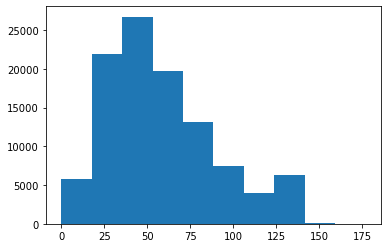

In [13]:
# checking histogram of character length
h = sorted(df1['CaptionText'].str.len().values)
import pylab as plt
plt.hist(h)
plt.show()

Histogram shows us that most memes are under 150 characters. I will use 128 as it will be easier to shape later in our model architecture.

In [14]:
# with max length=128, transform each row to a list of 128 integer values using tokenization
maxlen = 128
t = Tokenizer(char_level=True, lower=False)
t.fit_on_texts(df1['CaptionText'])
tokenized = t.texts_to_sequences(df1['CaptionText'])
text_labels = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen, padding='post')
print(text_labels.shape) # check shape of our padded, numerical text labels

(105099, 128)


In [15]:
text_labels[0] # checking how a single label looks like

array([35, 36,  1, 35, 16, 35,  1, 41, 30, 10, 20,  1, 22,  1, 40, 31, 19,
       36,  1, 41, 22, 18, 30,  1, 35, 36,  1, 40, 30, 16, 20, 10,  1, 42,
       16, 26,  1, 55, 46,  1, 35, 22, 20, 32, 18, 10, 25,  1, 35, 36,  1,
       35, 16, 35,  1, 41, 30, 10, 20,  1, 25, 30, 10,  1, 31, 16, 16, 44,
       25,  1, 19, 18,  1, 22, 20, 25, 18, 19, 38, 26, 19, 35,  1, 40, 30,
       16, 20, 10,  1, 42, 16, 26,  1, 18, 41, 16,  1, 30, 16, 32, 26, 25,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [16]:
int_labels = text_labels.astype(np.int) # change labels to int type

In [17]:
# check to see what our characters consist of (all alphanumeric characters plus a whitespace character)
print(t.word_index)

{' ': 1, 'E': 2, 'O': 3, 'T': 4, 'A': 5, 'I': 6, 'N': 7, 'S': 8, 'R': 9, 'e': 10, 'H': 11, 'L': 12, 'M': 13, 'D': 14, 'U': 15, 'o': 16, 'Y': 17, 't': 18, 'a': 19, 'n': 20, 'G': 21, 'i': 22, 'C': 23, 'W': 24, 's': 25, 'r': 26, 'P': 27, 'F': 28, 'B': 29, 'h': 30, 'l': 31, 'u': 32, 'K': 33, 'd': 34, 'm': 35, 'y': 36, 'V': 37, 'g': 38, 'c': 39, 'p': 40, 'w': 41, 'f': 42, 'b': 43, 'k': 44, 'v': 45, '0': 46, 'J': 47, '1': 48, 'X': 49, '2': 50, 'Z': 51, '9': 52, '5': 53, 'x': 54, '3': 55, 'Q': 56, 'j': 57, '4': 58, 'z': 59, '6': 60, '8': 61, '7': 62, 'q': 63}


In [18]:
# save only label and input data into new dataframe
new_df = df1[['CaptionText', 'img_array']]

In [19]:
new_df.head()

,CaptionText,img_array
0,my mom when i play with my phone for 30 minute...,"[[[150.0], [152.0], [152.0], [152.0], [154.0],..."
1,Doing your own research for a test Copy and pa...,"[[[148.0], [151.0], [152.0], [153.0], [154.0],..."
2,1 000 000 followers on tik tok 1 point on imgflip,"[[[149.0], [151.0], [152.0], [153.0], [154.0],..."
3,Making original memes Following the idea of an...,"[[[148.0], [151.0], [152.0], [153.0], [154.0],..."
4,M,"[[[149.0], [151.0], [152.0], [153.0], [154.0],..."


In [20]:
# remove all corrupted images from our preprocessed image arrays
cleanX = [x for x in images_as_array if str(x) != 'nan']

In [21]:
# divide all values by 255 for normalization between 0 and 1
cleanX1 = []
for i in cleanX:
    cleanX1.append(i / 255)

In [22]:
# check shape of a single image array
cleanX1[0].shape

(64, 64, 1)

In [23]:
# stack the array to fit into our model as it will require tensor shape
cleanX1 = np.stack(cleanX1)

In [24]:
cleanX1.shape

(105099, 64, 64, 1)

## Model

The model will consist of a convolution part with 6 convolution layers and 3 max pooling layers. Batch normalization layers will also be applied here for ease of data processing for our model.\
The convolution layer will then be connected end-to-end to a recurrent part through a flatten and reshape layer.\
There will be two bidirectional LSTM layers that will process the information picked up by the convolution part.\
This is be fed to a dense layer for 64 nodes, a node for each alphanumeric character to predict.

In [25]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64, 64, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 1)))

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))

model.add(BatchNormalization())
model.add(Flatten())
model.add(Reshape((128, 512), input_shape=(65536,)))

model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.2)))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)))

model.add(Dense(64, activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 256)       1

In [27]:
opt = Adam(learning_rate=0.001)

In [28]:
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.fit(x=cleanX1, y=int_labels, batch_size=64, epochs=25, validation_split=0.2, verbose=1)

Epoch 1/25
1314/1314 [==============================] - 140s 100ms/step - loss: 1.8183 - accuracy: 0.5860 - val_loss: 1.8916 - val_accuracy: 0.5599
Epoch 2/25
1314/1314 [==============================] - 134s 102ms/step - loss: 1.7882 - accuracy: 0.5894 - val_loss: 1.9028 - val_accuracy: 0.5599
Epoch 3/25
1314/1314 [==============================] - 133s 101ms/step - loss: 1.7830 - accuracy: 0.5902 - val_loss: 1.9949 - val_accuracy: 0.5599
Epoch 4/25
1314/1314 [==============================] - 134s 102ms/step - loss: 1.7799 - accuracy: 0.5905 - val_loss: 1.9173 - val_accuracy: 0.5573
Epoch 5/25
1314/1314 [==============================] - 134s 102ms/step - loss: 1.7781 - accuracy: 0.5907 - val_loss: 1.9056 - val_accuracy: 0.5585
Epoch 6/25
1314/1314 [==============================] - 131s 100ms/step - loss: 1.7765 - accuracy: 0.5908 - val_loss: 1.9367 - val_accuracy: 0.5608
Epoch 7/25
1314/1314 [==============================] - 133s 102ms/step - loss: 1.7753 - accuracy: 0.5909 - val_

## Save Model to local

In [41]:
model.save('model1')

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


In [42]:
from tensorflow import keras
loaded_model = keras.models.load_model('model1')